# Final Testing

In this notebook, we test the final model on a holdout set (set aside from competition training set) before we deploy our model for final submission. Also we create a prediction set from the competition test set.

In [1]:
import pandas as pd
import numpy as np
import pickle
import matplotlib.pyplot as plt
%matplotlib inline
from sklearn.metrics import accuracy_score, plot_confusion_matrix, classification_report

In [7]:
# import holdout test set
X_train = pd.read_pickle('PKL/X_train.pkl')
y_train = pd.read_pickle('PKL/y_train.pkl')
X_test = pd.read_pickle('PKL/X_test.pkl')
y_test = pd.read_pickle('PKL/y_test.pkl')

## Preprocessing train and test set

In [8]:
newfeats = pickle.load(open('PKL/new_feats.pkl', 'rb'))

In [9]:
# one-hot-encoding and standardization (if final model is KNN)
X_train = pd.get_dummies(X_train)
X_test = pd.get_dummies(X_test)

# Check if they have the same features
if X_train.shape[1] != X_test.shape[1]:
    print([x for x in X_train.columns if x not in X_test.columns])
    print([x for x in X_test.columns if x not in X_train.columns])
else: 
    print ('Good to go')

X_train = X_train[newfeats]
X_test = X_test[newfeats]

# Resample training set
from imblearn.over_sampling import SMOTE
smote = SMOTE()
X_train, y_train = smote.fit_sample(X_train, y_train)

# Standardizing training and testing set
from sklearn.preprocessing import StandardScaler

scale = StandardScaler()
X_train = scale.fit_transform(X_train)
X_test = scale.transform(X_test)

Good to go


### Dummy Prediction
Here we will look at the performance of stratified baseline model first.

Accuracy:  0.335
                         precision    recall  f1-score   support

             functional       0.56      0.33      0.42      8217
functional needs repair       0.07      0.33      0.11      1008
         non functional       0.39      0.34      0.36      5625

               accuracy                           0.34     14850
              macro avg       0.34      0.33      0.30     14850
           weighted avg       0.46      0.34      0.37     14850



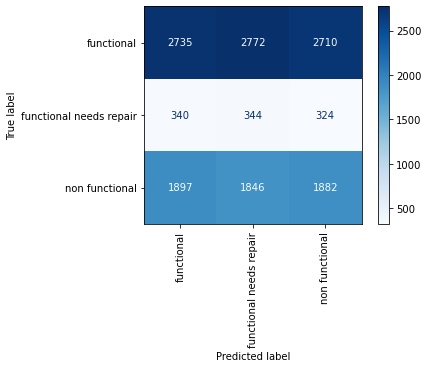

In [10]:
from sklearn.dummy import DummyClassifier
dummyc = DummyClassifier(strategy = 'stratified') # using the default stratified strategy
dummyc.fit(X_train, y_train)
y_pred = dummyc.predict(X_test)

accuracy = round(accuracy_score(y_test, y_pred), 3)

print('Accuracy: ', accuracy)

plot_confusion_matrix(dummyc, X_test, y_test, xticks_rotation = 'vertical', cmap = plt.cm.Blues)

print(classification_report(y_test, y_pred))

## Final Model Performance
Now we will import our final model, fit to the full training set, run prediction on the test set.

In [12]:
# import model
final_model = pickle.load(open('PKL/voting_c_soft.pkl', 'rb'))
# fit the full training set
final_model.fit(X_train, y_train)

VotingClassifier(estimators=[('knc_study',
                              KNeighborsClassifier(algorithm='kd_tree',
                                                   n_jobs=-1, n_neighbors=4,
                                                   p=1, weights='distance')),
                             ('rf_model',
                              RandomForestClassifier(class_weight='balanced',
                                                     max_features=135,
                                                     max_leaf_nodes=200,
                                                     min_samples_leaf=2,
                                                     min_samples_split=5,
                                                     min_weight_fraction_leaf=2.2193985313288622e-07,
                                                     n_estimators=466,
                                                     n_jobs=-1,
                                                     oob_score...
                

Accuracy:  0.798
                         precision    recall  f1-score   support

             functional       0.83      0.85      0.84      8217
functional needs repair       0.42      0.48      0.45      1008
         non functional       0.83      0.78      0.81      5625

               accuracy                           0.80     14850
              macro avg       0.69      0.70      0.70     14850
           weighted avg       0.80      0.80      0.80     14850



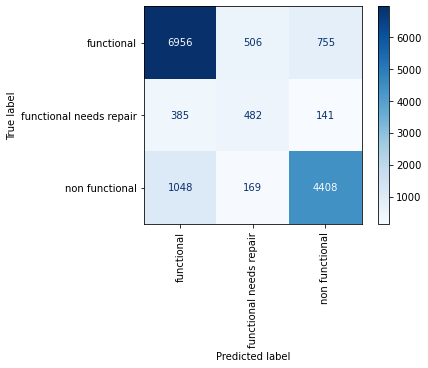

In [13]:
# predict and plot performance
y_pred = final_model.predict(X_test)

accuracy = round(accuracy_score(y_test, y_pred), 3)

print('Accuracy: ', accuracy)
print(classification_report(y_test, y_pred))

plot_confusion_matrix(final_model, X_test, y_test, xticks_rotation = 'vertical', cmap = plt.cm.Blues)



Sensitivity for the minority class is great. It's overpredicting the minority class, which is better than underpredicting the minority class in our case. Overall accuracy is probably not as good as other model including voting classifier and XGBoost, but knowing when the well is not functioning is much more important than knowing when the well is functioning.

**(Below are for competition submission, not relevant for the project.)**

Now we will make a prediction for the competition test set. We don't have the labels for this data, but we will output a prediction.

In [14]:
# fit the full dataset
X_full = pd.read_pickle('PKL/X_full.pkl')
y_full = pd.read_pickle('PKL/y_full.pkl')
# get dummies
X_full = pd.get_dummies(X_full)
X_full = X_full[newfeats]
# resample
X_full, y_full = smote.fit_sample(X_full, y_full)
# standardize
scale = StandardScaler()
X_full = scale.fit_transform(X_full)
# final fit
final_model.fit(X_full, y_full)

VotingClassifier(estimators=[('knc_study',
                              KNeighborsClassifier(algorithm='kd_tree',
                                                   n_jobs=-1, n_neighbors=4,
                                                   p=1, weights='distance')),
                             ('rf_model',
                              RandomForestClassifier(class_weight='balanced',
                                                     max_features=135,
                                                     max_leaf_nodes=200,
                                                     min_samples_leaf=2,
                                                     min_samples_split=5,
                                                     min_weight_fraction_leaf=2.2193985313288622e-07,
                                                     n_estimators=466,
                                                     n_jobs=-1,
                                                     oob_score...
                

In [25]:
# import the final test set
X_submission = pd.read_csv('DATA/TEST_VALUES.csv')

In [27]:
ids = X_submission['id']

In [28]:
# run preprocessing on test set
from importlib import reload 
import preprocessing_pipeline
reload( preprocessing_pipeline )
from preprocessing_pipeline import preprocessing


X_submission = preprocessing(X_submission)

# one-hot-encoding and standardization (if final model is KNN)
X_submission = pd.get_dummies(X_submission)

X_submission = X_submission[newfeats]
    
# standardize
X_submission = scale.transform(X_submission)

In [29]:
# predict and plot performance
y_pred = final_model.predict(X_submission)

In [33]:
submission = pd.DataFrame(zip(ids, y_pred), columns = ['id', 'status_group'])

In [34]:
# save the submission
submission.to_csv('submission.csv', index = False)